In [9]:
#hide
import fastbook
fastbook.setup_book()

# Zadanie minimum

Wykorzystamy przykład z [fastbook](https://github.com/fastai/fastbook/blob/master/02_production.ipynb):

In [10]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [11]:
path = Path('loko')

In [12]:
loko = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [13]:
#hide
dls = loko.dataloaders(path)

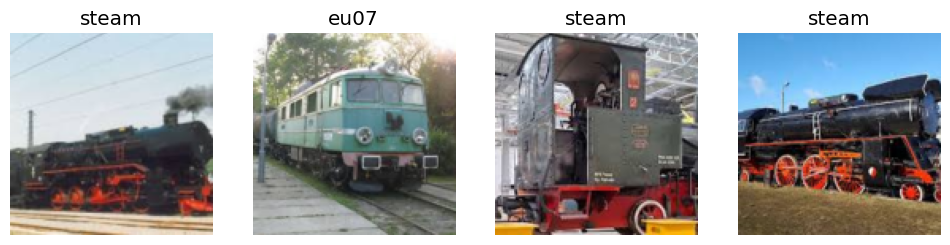

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

### Przygotowanie danych

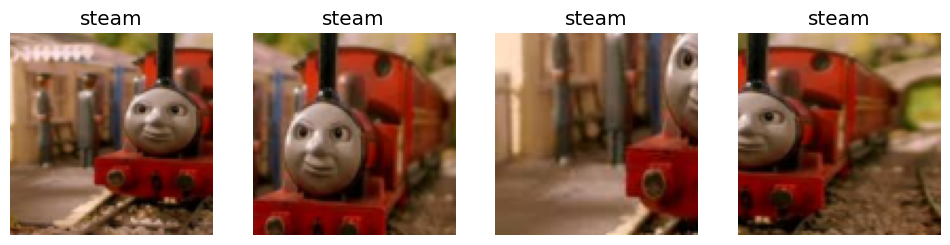

In [15]:
loko = loko.new(item_tfms=RandomResizedCrop(96, min_scale=0.1))
dls = loko.dataloaders(path, bs=20)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

In [16]:
#hide
loko = loko.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1.5))
dls = loko.dataloaders(path, bs=25)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash 2236df1770800ffea5697b11b0bb0d910b2e59e1. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

### Trenowanie

Wykorzystamy istniejący model [rosnet18](https://fastai1.fast.ai/vision.models.html).

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5) # można poeksperymentować

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(6, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export() # Eksport przetrenowanego modelu (może się przydać przy użytku w innym projekcie)

In [ ]:
path = Path()
learn_inf = load_learner(path/'export.pkl') # import zapisanego wyżej modelu (tak dla zasady)

In [22]:
out_pl = widgets.Output()
out_pl.clear_output()
btn_upload = SimpleNamespace(data = ['loko/steam/images-10.jpeg'])
img = PILImage.create(btn_upload.data[-1])
with out_pl: display(img.to_thumb(256,256))
btn_run = widgets.Button(description='Classify')
lbl_pred = widgets.Label()
lbl_pred.value = ""

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

def on_upload_change(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(256,256))

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()
btn_upload.observe(on_upload_change, names='_counter')
VBox([widgets.Label("Let's find out how it works!"), btn_upload, btn_run, out_pl, lbl_pred])